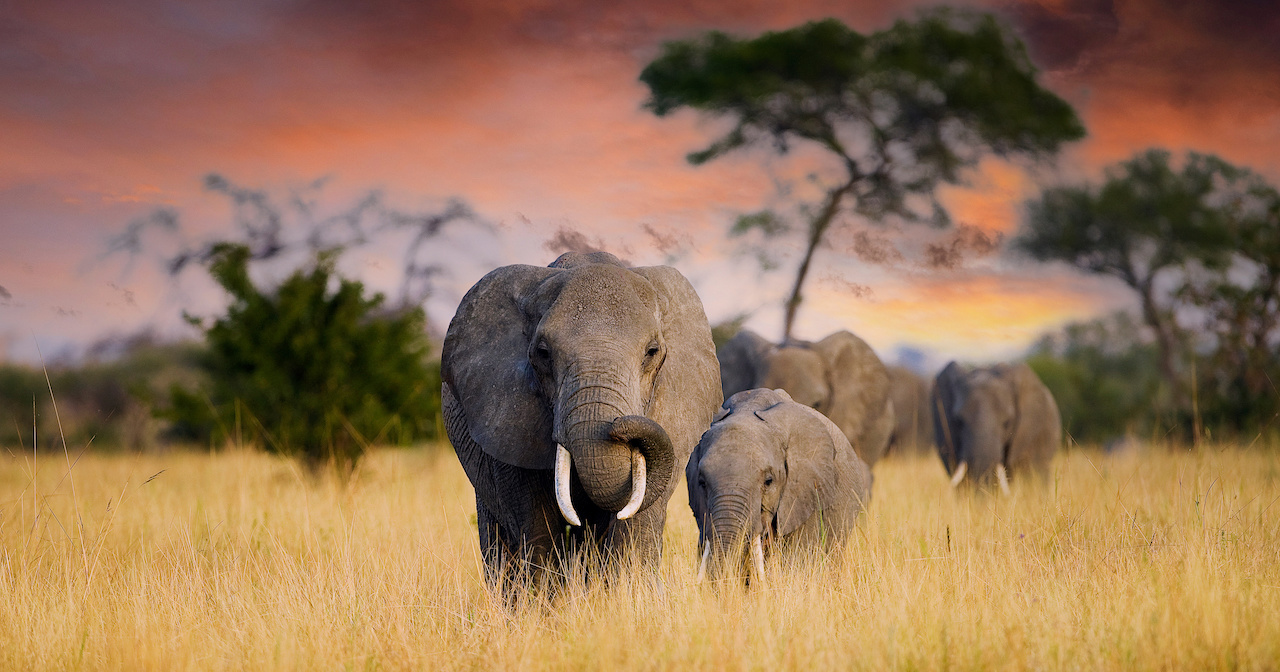
Photo by <a href="https://stock.adobe.com/contributor/19000/mat-hayward?load_type=author&prev_url=detail" >Mat Hayward</a> on Adobe Stock

# Phase 4 Project: *The Met Museum Ivory Art Classification Model*

### By Ryan Posternak and Harrison Carter

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 6th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify whether a piece of artwork among the Met museum's art collection is made of ivory or not

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Sourcing the Data

### Import libraries, packages and modules

In [463]:
import numpy as np
import pandas as pd
import requests
import time
import random
from PIL import Image
import imagesize
from pathlib import Path
from io import BytesIO
import os
import shutil

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from keras import models, layers
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

### Connect to Met API

In [2]:
# API URL to obtain IDs of ivory objects
ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ivory&q=*'

# API URL to obtain IDs of (expected to be) non-ivory ceramic objects
non_ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ceramics&hasImages=true&q=*'

# Ivory objects request
ivory_r = requests.get(ivory_url)

# Non-ivory objects request
non_ivory_r = requests.get(non_ivory_url)

ivory_r.status_code, non_ivory_r.status_code

(200, 200)

In [3]:
# Retrieve objectIds
ivory_objectIDs = ivory_r.json()['objectIDs']
non_ivory_objectIDs = non_ivory_r.json()['objectIDs']


print(f"Number of ivory objects: {len(ivory_objectIDs)}")
print(f"Number of ceramic objects: {len(non_ivory_objectIDs)}")

Number of ivory objects: 5975
Number of ceramic objects: 25603


In [4]:
# Let's view the full data on one museum art piece (the first ivory object in our list)
url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

requests.get(url + str(ivory_objectIDs[0])).json()

{'objectID': 248694,
 'isHighlight': False,
 'accessionNumber': '12.229.23b',
 'accessionYear': '1912',
 'isPublicDomain': True,
 'primaryImage': 'https://images.metmuseum.org/CRDImages/gr/original/sf1222923b.jpg',
 'primaryImageSmall': 'https://images.metmuseum.org/CRDImages/gr/web-large/sf1222923b.jpg',
 'additionalImages': [],
 'constituents': None,
 'department': 'Greek and Roman Art',
 'objectName': 'Relief of a duck',
 'title': 'Relief of a duck',
 'culture': 'Roman',
 'period': 'Early Imperial',
 'dynasty': '',
 'reign': '',
 'portfolio': '',
 'artistRole': '',
 'artistPrefix': '',
 'artistDisplayName': '',
 'artistDisplayBio': '',
 'artistSuffix': '',
 'artistAlphaSort': '',
 'artistNationality': '',
 'artistBeginDate': '',
 'artistEndDate': '',
 'artistGender': '',
 'artistWikidata_URL': '',
 'artistULAN_URL': '',
 'objectDate': '1st century A.D.',
 'objectBeginDate': 1,
 'objectEndDate': 99,
 'medium': 'Bone',
 'dimensions': '1 13/16 × 5/8 × 4 3/16 in. (4.7 × 1.6 × 10.6 cm)',

### Create container lists with selected attributes

In [5]:
# # Initialize lists
# ivory_primaryImageSmall_urls = []
# ivory_titles = []
# ivory_objectNames = []
# ivory_mediums = []
# ivory_classifications = []
# ivory_departments = []
# ivory_cultures = []
# ivory_periods = []
# ivory_objectDates = []

# # Compile containers
# attribute_containers = [ivory_primaryImageSmall_urls, ivory_titles, ivory_objectNames, ivory_mediums, 
#                         ivory_classifications, ivory_departments, ivory_cultures, ivory_periods, ivory_objectDates]

# # Compile key names of attributes
# attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
#               'classification', 'department', 'culture', 'period', 'objectDate']

# # Execute API requests
# objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'
# if os.path.isfile('data/final_df.csv') == False:  # Prevent running duplicate API requests
#     for objectID in ivory_objectIDs:
#         r = requests.get(objects_url + str(objectID))
#         for attribute_container, attribute in zip(attribute_containers, attributes):
#             try:
#                 attribute_container.append(r.json()[attribute])
#             except:
#                 attribute_container.append(np.nan)  # Some keys are missing on select objects
#         time.sleep(1/160)  # Throttle API request rate to conform with API documentation

### Create dataframe of ivory art pieces

In [6]:
ivory_df = pd.DataFrame(ivory_objectIDs, columns=['Object_ID'])

ivory_df['Image_URL'] = ivory_primaryImageSmall_urls
ivory_df['Title'] = ivory_titles
ivory_df['Object_Name'] = ivory_objectNames
ivory_df['Medium'] = ivory_mediums
ivory_df['Classification'] = ivory_classifications
ivory_df['Department'] = ivory_departments
ivory_df['Culture'] = ivory_cultures
ivory_df['Period'] = ivory_periods
ivory_df['Object_Date'] = ivory_objectDates

# Ivory art pieces will have class labels of 1
ivory_df['Target'] = 1

ivory_df.replace(to_replace='', value=np.nan, inplace=True)

print(ivory_df.shape)
ivory_df.head()

(5975, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,25138,NaN,Dirk with Sheath,Dirk with sheath,"Steel, ivory, leather, gold",Daggers,Arms and Armor,French,NaN,16th century,1
4,25137,NaN,Cinquedea,Cinquedea,"Steel, brass, ivory, gold, latten",Daggers,Arms and Armor,Italian,NaN,1525–50,1


In [7]:
# How many of the ivory objects have valid (small) image URLs?
num_ivory_objects_with_image = ivory_df.shape[0] - ivory_df.Image_URL.isna().sum()
num_ivory_objects_with_image

4617

In [8]:
# Choose 5,975 random objectIds from the non_ivory_objectIDs list
np.random.seed(10)
selected_non_ivory_objectIDs = np.random.choice(non_ivory_objectIDs, size=5975, replace=False)
len(selected_non_ivory_objectIDs)

5975

### Repeat steps above to create dataframe of non-ivory art pieces

In [9]:
# non_ivory_primaryImageSmall_urls = []
# non_ivory_titles = []
# non_ivory_objectNames = []
# non_ivory_mediums = []
# non_ivory_classifications = []
# non_ivory_departments = []
# non_ivory_cultures = []
# non_ivory_periods = []
# non_ivory_objectDates = []

# attribute_containers = [non_ivory_primaryImageSmall_urls, non_ivory_titles, non_ivory_objectNames, 
#                         non_ivory_mediums, non_ivory_classifications, non_ivory_departments, non_ivory_cultures, 
#                         non_ivory_periods, non_ivory_objectDates]

# attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
#               'classification', 'department', 'culture', 'period', 'objectDate']


# objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

# if os.path.isfile('data/final_df.csv') == False:  # Prevent running duplicate API requests
#     for objectID in selected_non_ivory_objectIDs:
#         r = requests.get(objects_url + str(objectID))
#         for attribute_container, attribute in zip(attribute_containers, attributes):
#             try:
#                 attribute_container.append(r.json()[attribute])
#             except:
#                 attribute_container.append(np.nan)
#         time.sleep(1/160)

In [10]:
non_ivory_df = pd.DataFrame(selected_non_ivory_objectIDs, columns=['Object_ID'])

non_ivory_df['Image_URL'] = non_ivory_primaryImageSmall_urls
non_ivory_df['Title'] = non_ivory_titles
non_ivory_df['Object_Name'] = non_ivory_objectNames
non_ivory_df['Medium'] = non_ivory_mediums
non_ivory_df['Classification'] = non_ivory_classifications
non_ivory_df['Department'] = non_ivory_departments
non_ivory_df['Culture'] = non_ivory_cultures
non_ivory_df['Period'] = non_ivory_periods
non_ivory_df['Object_Date'] = non_ivory_objectDates

# Non-ivory art pieces will have class labels of 0
non_ivory_df['Target'] = 0

# Remove objects without valid (small) image URLs
non_ivory_df.replace(to_replace='', value=np.nan, inplace=True)
non_ivory_df.dropna(subset=['Image_URL'], inplace=True)

print(non_ivory_df.shape)
non_ivory_df.head()

(5320, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,186685,https://images.metmuseum.org/CRDImages/es/web-...,Bowl with Saint Francis receiving the stigmata,Bowl,"Maiolica (tin-glazed earthenware), lustered",Ceramics-Pottery,European Sculpture and Decorative Arts,NaN,NaN,16th century,0
1,194344,https://images.metmuseum.org/CRDImages/es/web-...,Plate,Plate,Faience (tin-glazed earthenware),Ceramics-Pottery,European Sculpture and Decorative Arts,NaN,NaN,1730–1800,0
2,47555,https://images.metmuseum.org/CRDImages/as/web-...,Plate,Plate,Porcelain,Ceramics,Asian Art,China,Ming dynasty (1368–1644),NaN,0
4,48435,https://images.metmuseum.org/CRDImages/as/web-...,Model of a stove,Model of a stove,Earthenware with green glaze,Tomb Pottery,Asian Art,China,Han dynasty (206 B.C.–A.D. 220),1st–2nd century,0
6,695250,https://images.metmuseum.org/CRDImages/md/web-...,Fragment,Fragment,"Glass, ceramic",Glass-Vessels,Medieval Art,European or Middle Eastern,NaN,ca. 1150–ca. 1250,0


### Concatenate dataframes

In [11]:
merged_df = pd.concat([ivory_df, non_ivory_df], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(11295, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,25138,NaN,Dirk with Sheath,Dirk with sheath,"Steel, ivory, leather, gold",Daggers,Arms and Armor,French,NaN,16th century,1
4,25137,NaN,Cinquedea,Cinquedea,"Steel, brass, ivory, gold, latten",Daggers,Arms and Armor,Italian,NaN,1525–50,1


# Data Preprocessing

### Drop duplicate object IDs, null image URLs, and duplicate image URLs

In [12]:
print('Before preprocessing:' + '\n')

# Search for duplicate Object_IDs
num_dup_IDs = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]
print(str(num_dup_IDs) + ' duplicate Object_IDs')

# Remove from dataframe (keep first occurrence)
dup_ID_indexes = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].index
merged_df = merged_df.drop(dup_ID_indexes)

# Search for NaN Image_URLs
num_NaN_Image_URLs = merged_df.loc[merged_df['Image_URL'].isna()].shape[0]
print(str(num_NaN_Image_URLs) + ' null Image_URLs')

# Remove from dataframe
NaN_Image_URL_indexes = merged_df.loc[merged_df['Image_URL'].isna()].index
merged_df = merged_df.drop(NaN_Image_URL_indexes)

# Search for duplicate Image_URLs
num_dup_Image_URLs = merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]
print(str(num_dup_Image_URLs) + ' duplicate Image_URLs')

# Remove from dataframe (keep first occurrence)
dup_Image_URL_indexes = merged_df.loc[merged_df.duplicated(subset='Image_URL')].index
merged_df = merged_df.drop(dup_Image_URL_indexes)

print('-'*30)
print('After preprocessing:' + '\n')
print(str(merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]) + ' duplicate Object_IDs')
print(str(merged_df.loc[merged_df['Image_URL'].isna()].shape[0]) + ' null Image_URLs')
print(str(merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]) + ' duplicate Image_URLs')

Before preprocessing:

22 duplicate Object_IDs
1358 null Image_URLs
160 duplicate Image_URLs
------------------------------
After preprocessing:

0 duplicate Object_IDs
0 null Image_URLs
0 duplicate Image_URLs


In [13]:
# Let's preview the mediums of our ivory objects
merged_df.loc[merged_df.Target == 1].Medium.value_counts()[:30]

Ivory                                           1382
Watercolor on ivory                              562
Bone                                             140
Bone; incised and inlaid with paint              125
Bone; tinted, incised, and inlaid with paint      53
Elephant ivory                                    53
Bone; carved                                      32
Wood; carved, inlaid with ivory                   31
Ivory (walrus)                                    31
ivory                                             27
Walrus ivory                                      26
Steel, ivory                                      23
Bone; incised                                     23
Ivory with metal mounts                           20
Ivory or bone                                     19
Wood, ivory                                       17
Paper, ivory                                      17
Silver, ivory                                     16
Wood; inlaid with ivory                       

4230
Ivory


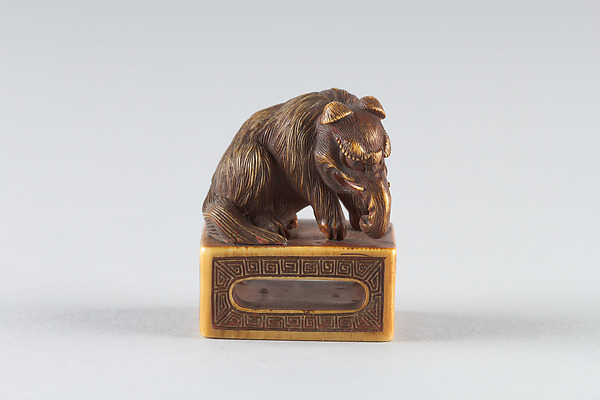

1658
Ivory


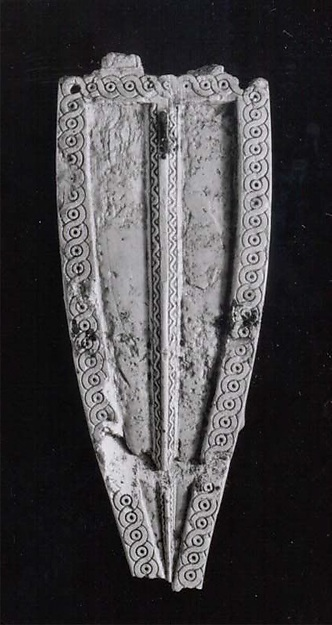

1853
Ivory


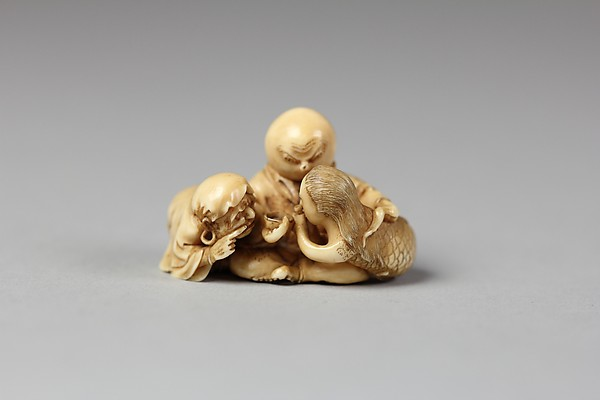

In [14]:
# These are the art mediums that appear most relevant to our search for ivory objects. The others might hardly 
# have any trace of bone/ivory for the model to pick up on. We'll also include other forms of ivory besides 
# elephant ivory, such as walrus ivory, due to the similarity in appearance.
ivory_indexes_to_keep = merged_df.loc[(merged_df.Medium == 'Ivory') | 
                                      (merged_df.Medium == 'Bone') | 
                                      (merged_df.Medium == 'Bone, ivory') | 
                                      (merged_df.Medium == 'Elephant ivory') | 
                                      (merged_df.Medium == 'Bone; carved') | 
                                      (merged_df.Medium == 'Ivory (walrus)') | 
                                      (merged_df.Medium == 'ivory') | 
                                      (merged_df.Medium == 'Walrus ivory') | 
                                      (merged_df.Medium == 'Bone; incised') | 
                                      (merged_df.Medium == 'Ivory with metal mounts') | 
                                      (merged_df.Medium == 'Ivory or bone') | 
                                      (merged_df.Medium == 'Ivory (elephant)')
                                     ].index

# Let's preview three items from above
np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

970
Wood; carved, inlaid with plain and carved ivory


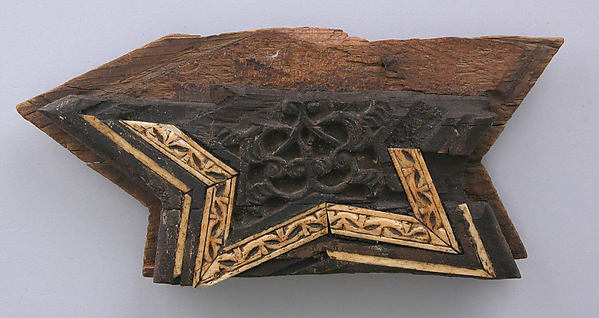

5948
Ivory, gold


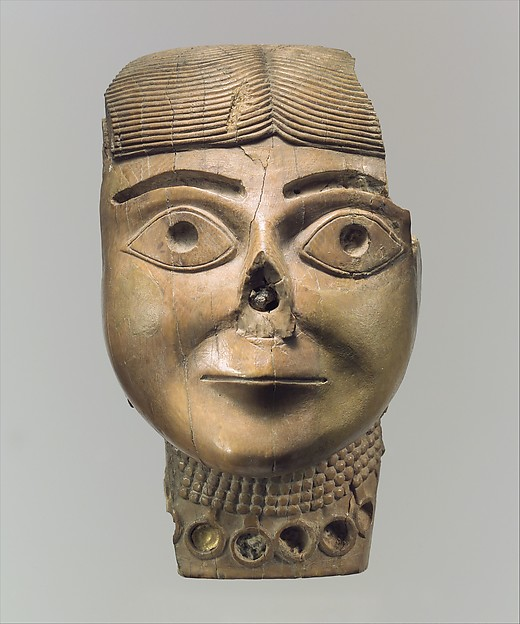

2649
Carved ivory; mounted over wood frame; brass mounts


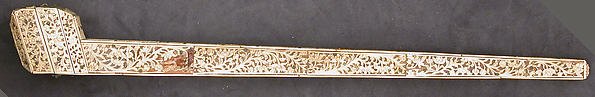

In [15]:
# Just to be sure, let's preview three items that don't fit the medium descriptions above, to see if they are 
# still recognizable as ivory or not
all_ivory_indexes = merged_df.loc[merged_df.Target == 1].index
ivory_indexes_to_drop = [index for index in all_ivory_indexes if index not in ivory_indexes_to_keep]

np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_drop, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

**Remarks**:
- As suspected, the images not among the selected mediums appear to have little, if any, traces of ivory, although ivory may be some element of their composition. We'll go ahead and keep only the items among the selected mediums. Even though this will be costly in terms of lost data, these art pieces we're dropping would likely bring more noise than signal.

In [16]:
new_ivory_df = merged_df.loc[ivory_indexes_to_keep]
print(new_ivory_df.shape)
new_ivory_df.head()

(1770, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
16,31064,https://images.metmuseum.org/CRDImages/aa/web-...,Sword with Scabbard,Sword with scabbard,Ivory,Swords,Arms and Armor,Batak,NaN,16th–19th century,1
72,34077,https://images.metmuseum.org/CRDImages/aa/web-...,Hilt of a Dagger,Hilt of a dagger,Ivory,Daggers,Arms and Armor,"possibly Italian, Venice",NaN,ca. 1300,1


In [17]:
# To maintain a balanced dataset, let's now select 1,770 (random) art pieces from among the non-ivory items

np.random.seed(42)
non_ivory_indexes_to_keep = np.random.choice(merged_df.loc[merged_df['Target'] == 0].index, 
                                             size=1770, 
                                             replace=False)

new_non_ivory_df = merged_df.loc[non_ivory_indexes_to_keep]
print(new_non_ivory_df.shape)
new_non_ivory_df.head()

(1770, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
6398,461221,https://images.metmuseum.org/CRDImages/rl/web-...,Small covered wine pot or teapot,Covered winepot or teapot,Porcelain painted in overglaze famille verte e...,Ceramics,Robert Lehman Collection,Chinese,NaN,1662–1722,0
8492,449783,https://images.metmuseum.org/CRDImages/is/web-...,Bowl,Bowl,"Earthenware; black slip, decoration in white, ...",Ceramics,Islamic Art,NaN,NaN,9th–10th century,0
5998,48118,https://images.metmuseum.org/CRDImages/as/web-...,Bowl,Bowl,Dark brown ware with thick black glaze (Jian w...,Ceramics,Asian Art,China,Yuan dynasty (1271–1368),NaN,0
7342,47949,https://images.metmuseum.org/CRDImages/as/web-...,Jar,Jar,Clay covered with crackled glaze and streaks (...,Ceramics,Asian Art,Japan,Edo (1615–1868) or Meiji period (1868–1912),19th century,0
7432,197911,https://images.metmuseum.org/CRDImages/es/web-...,Plate (assiette à palmes) (1 of 102) (part of ...,Plate,Soft-paste porcelain,Ceramics-Porcelain,European Sculpture and Decorative Arts,NaN,NaN,1787,0


7248
Porcelain painted in overglaze polychrome enamels (Bencharong ware for Thai market)


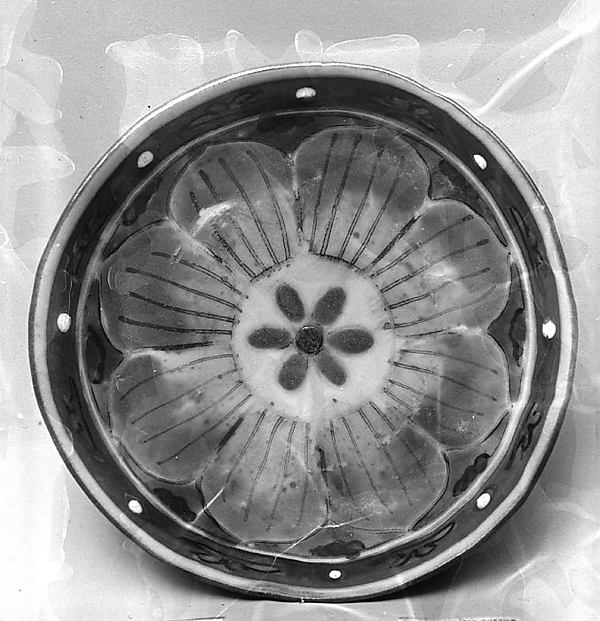

8055
Porcelain with famille verte enamels


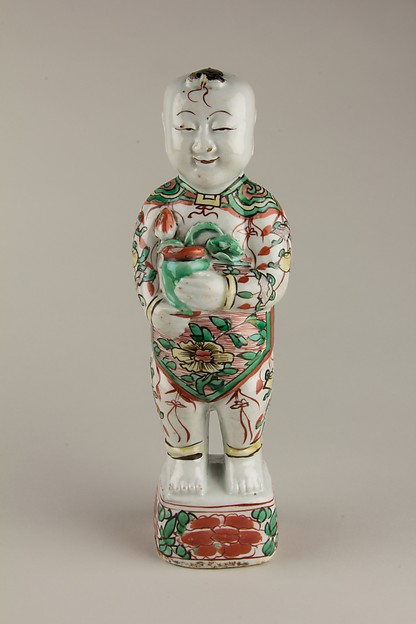

11201
Stoneware with iron-oxide glaze (Jian ware)


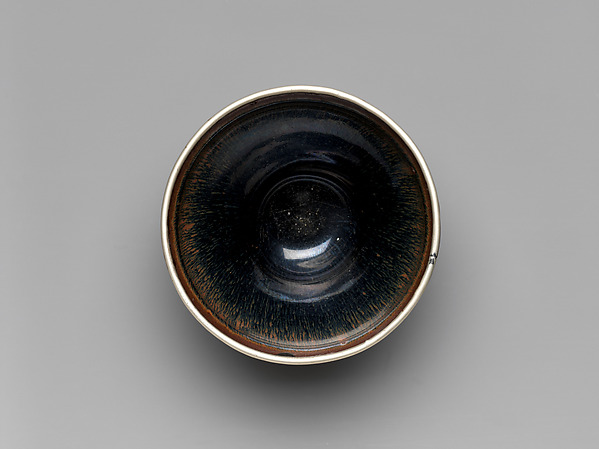

In [18]:
# Let's preview what some non-ivory art pieces look like, to compare
np.random.seed(45)
for index in np.random.choice(non_ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

### Concatenate new dataframes

In [19]:
final_df = pd.concat([new_ivory_df, new_non_ivory_df], ignore_index=True)
print(final_df.shape)
final_df.head()

(3540, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,31064,https://images.metmuseum.org/CRDImages/aa/web-...,Sword with Scabbard,Sword with scabbard,Ivory,Swords,Arms and Armor,Batak,NaN,16th–19th century,1
4,34077,https://images.metmuseum.org/CRDImages/aa/web-...,Hilt of a Dagger,Hilt of a dagger,Ivory,Daggers,Arms and Armor,"possibly Italian, Venice",NaN,ca. 1300,1


### Save images to data folder

In [24]:
ivory_indexes = final_df.loc[final_df['Target'] == 1].index
non_ivory_indexes = final_df.loc[final_df['Target'] == 0].index

# Sanity check
ivory_indexes.shape[0] + non_ivory_indexes.shape[0] == final_df.shape[0]

True

In [27]:
ivory_dir_len = len([name for name in os.listdir('data/images/ivory') if not name.endswith('checkpoints')])

unidentified_ivory_images = []

if ivory_dir_len == 0:
    for index in ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/ivory/ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_ivory_images.append(index)
        
unidentified_ivory_images

[924]

In [28]:
non_ivory_dir_len = len([name for name in os.listdir('data/images/non_ivory') if not name.endswith('checkpoints')])

unidentified_non_ivory_images = []

if non_ivory_dir_len == 0:
    for index in non_ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/non_ivory/non_ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_non_ivory_images.append(index)
            
unidentified_non_ivory_images

[1996, 2233, 2288]

### Drop rows with invalid image URLs

In [148]:
final_df = final_df.drop(unidentified_ivory_images)
final_df = final_df.drop(unidentified_non_ivory_images)

# Reset indexes
final_df.index = range(len(final_df))

print(f"Total items in dataset: {final_df.shape[0]}")
final_df.Target.value_counts()

Total items in dataset: 3536


1    1769
0    1767
Name: Target, dtype: int64

### Save dataframe as .csv file

In [39]:
if os.path.isfile('data/final_df.csv') == False:
    final_df.to_csv('data/final_df.csv')
else:
    final_df = pd.read_csv('data/final_df.csv', index_col=0)

### Create train, validation, and test splits of ivory and non-ivory images

In [118]:
data_ivory_dir = 'data/images/ivory/'
data_non_ivory_dir = 'data/images/non_ivory/'
split_dir = 'data/split/'

test_ivory = 'data/split/test/ivory/'
test_non_ivory = 'data/split/test/non_ivory/'

validation_ivory = 'data/split/validation/ivory/'
validation_non_ivory = 'data/split/validation/non_ivory/'

train_ivory = 'data/split/train/ivory/'
train_non_ivory = 'data/split/train/non_ivory/'

In [102]:
imgs_ivory = [file for file in os.listdir(data_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_ivory)

print('There are', len(imgs_ivory), 'ivory images')
imgs_ivory[:3]

There are 1769 ivory images


['ivory_11946.jpg', 'ivory_31546.jpg', 'ivory_209526.jpg']

In [103]:
imgs_non_ivory = [file for file in os.listdir(data_non_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_non_ivory)

print('There are', len(imgs_non_ivory), 'non-ivory images')
imgs_non_ivory[:3]

There are 1767 non-ivory images


['non_ivory_196599.jpg', 'non_ivory_168773.jpg', 'non_ivory_202636.jpg']

In [104]:
# We'll do an 80/20 train/test split; of the training data, we'll do another 80/20 train/validation split

print(f"Ivory test images slice:        {int(1769*0.8)+1}:1769  --> {int(1769*0.2)} images")
print(f"Ivory validation images slice:  {int(1415*0.8)+1}:{int(1769*0.8)+1}  --> {int(1415*0.2)} images")
print(f"Ivory train images slice:       0:{int(1415*0.8)+1}     --> {int(1415*0.8)+1} images")

Ivory test images slice:        1416:1769  --> 353 images
Ivory validation images slice:  1133:1416  --> 283 images
Ivory train images slice:       0:1133     --> 1133 images


In [105]:
# Repeat for non-ivory images

print(f"Non-ivory test images slice:        {int(1767*0.8)+1}:1767  --> {int(1767*0.2)} images")
print(f"Non-ivory validation images slice:  {int(1414*0.8)+1}:{int(1767*0.8)+1}  --> {int(1414*0.2)} images")
print(f"Non-ivory train images slice:       0:{int(1414*0.8)+1}     --> {int(1414*0.8)+1} images")

Non-ivory test images slice:        1414:1767  --> 353 images
Non-ivory validation images slice:  1132:1414  --> 282 images
Non-ivory train images slice:       0:1132     --> 1132 images


In [125]:
# Test ivory images
imgs = imgs_ivory[1416:1769]
dir_length = len([name for name in os.listdir('data/split/test/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(test_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation ivory images
imgs = imgs_ivory[1133:1416]
dir_length = len([name for name in os.listdir('data/split/validation/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(validation_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train ivory images
imgs = imgs_ivory[0:1133]
dir_length = len([name for name in os.listdir('data/split/train/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(train_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_ivory)), 'ivory images in the test set')
print('There are', len(os.listdir(validation_ivory)), 'ivory images in the validation set')
print('There are', len(os.listdir(train_ivory)), 'ivory images in the train set')

There are 353 ivory images in the test set
There are 283 ivory images in the validation set
There are 1133 ivory images in the train set


In [127]:
# Test non-ivory images
imgs = imgs_non_ivory[1414:1767]
dir_length = len([name for name in os.listdir('data/split/test/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(test_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation non-ivory images
imgs = imgs_non_ivory[1132:1414]
dir_length = len([name for name in os.listdir('data/split/validation/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(validation_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train non-ivory images
imgs = imgs_non_ivory[0:1132]
dir_length = len([name for name in os.listdir('data/split/train/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(train_non_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_non_ivory)), 'non-ivory images in the test set')
print('There are', len(os.listdir(validation_non_ivory)), 'non-ivory images in the validation set')
print('There are', len(os.listdir(train_non_ivory)), 'non-ivory images in the train set')

There are 353 non-ivory images in the test set
There are 282 non-ivory images in the validation set
There are 1132 non-ivory images in the train set


### Examine image resolutions

In [170]:
# Get image resolutions
ivory_imgs_sizes = [img.name for img in Path('data/images/ivory/').iterdir() if img.suffix == ".jpg"]
non_ivory_imgs_sizes = [img.name for img in Path('data/images/non_ivory/').iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in ivory_imgs_sizes: img_meta[str(f)] = imagesize.get('data/images/ivory/'+f)
for f in non_ivory_imgs_sizes: img_meta[str(f)] = imagesize.get('data/images/non_ivory/'+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns')
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total number of images in dataset: {len(img_meta_df)}')
img_meta_df.head()

Total number of images in dataset: 3536


,FileName,Size,Width,Height,Aspect Ratio
0,ivory_58504.jpg,"(600, 560)",600,560,1.07
1,ivory_209813.jpg,"(600, 230)",600,230,2.61
2,ivory_209807.jpg,"(145, 621)",145,621,0.23
3,ivory_121855.jpg,"(599, 411)",599,411,1.46
4,ivory_545856.jpg,"(600, 400)",600,400,1.50


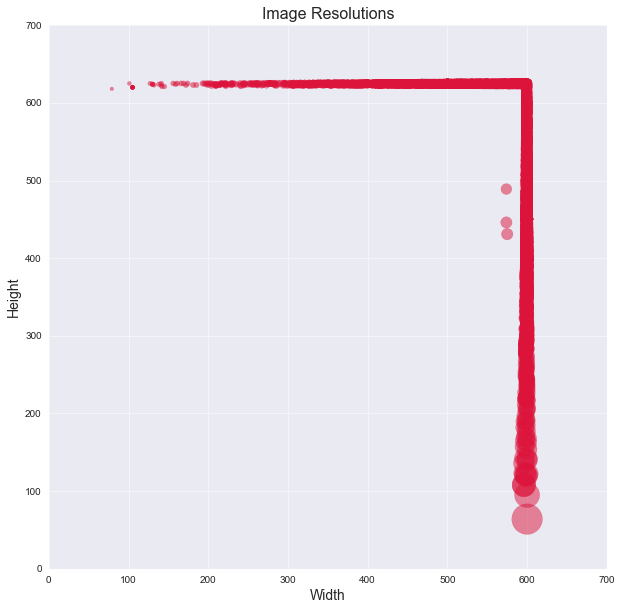

In [204]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(img_meta_df.Width, img_meta_df.Height, color='crimson', alpha=0.5, s=img_meta_df['Aspect Ratio']*100)
ax.set_title('Image Resolutions', size=16)
ax.set_xlabel('Width', size=14)
ax.set_ylabel('Height', size=14)
ax.set_xticks(list(range(0, 800, 100)))
ax.set_yticks(list(range(0, 800, 100)))
ax.grid(alpha=0.5);

In [251]:
test_folder = os.path.join(split_dir, 'test')
validation_folder = os.path.join(split_dir, 'validation')
train_folder = os.path.join(split_dir, 'train')


# Get all the data in the directory data/split/test (706 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, 
                                                                        classes=['non_ivory', 'ivory'], 
                                                                        target_size=(256, 256), batch_size=706) 

# Get all the data in the directory data/split/validation (565 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_folder, 
                                                                       classes=['non_ivory', 'ivory'], 
                                                                       target_size=(256, 256), batch_size=565)

# Get all the data in the directory data/split/train (2265 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, 
                                                                         classes=['non_ivory', 'ivory'], 
                                                                         target_size=(256, 256), batch_size=2265)

train_generator.class_indices

Found 706 images belonging to 2 classes.
Found 565 images belonging to 2 classes.
Found 2265 images belonging to 2 classes.


{'non_ivory': 0, 'ivory': 1}

In [242]:
# Create the data sets
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)
train_images, train_labels = next(train_generator)

In [262]:
# Explore the dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))

Number of training samples: 2265
Number of testing samples: 706
Number of validation samples: 565
----------------------------------------
test_images shape: (706, 256, 256, 3)
test_labels shape: (706, 2)
----------------------------------------
val_images shape: (565, 256, 256, 3)
val_labels shape: (565, 2)
----------------------------------------
train_images shape: (2265, 256, 256, 3)
train_labels shape: (2265, 2)


In [252]:
# Function that plots images and labels
def plot_images(ims, figsize=(20,4), rows=1, interp=False, titles=None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

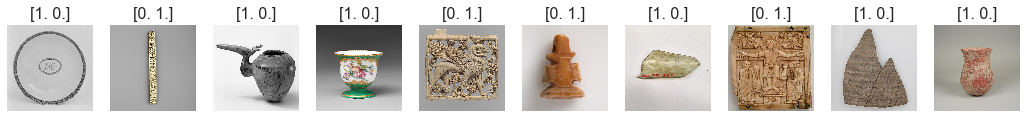

In [256]:
# View first 10 items from train_images
plot_images(train_images[0:10], titles=train_labels[0:10])

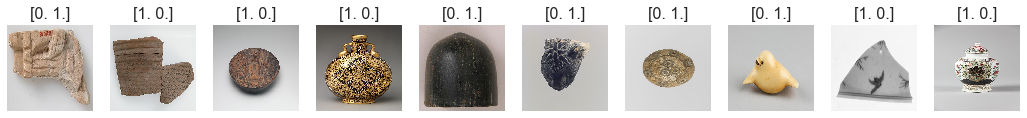

In [257]:
# View first 10 items from test_images
plot_images(test_images[0:10], titles=test_labels[0:10])

In [263]:
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
train_img = train_images.reshape(train_images.shape[0], -1)

print(test_img.shape)
print(val_img.shape)
print(train_img.shape)

(706, 196608)
(565, 196608)
(2265, 196608)


In [266]:
test_y = np.reshape(test_labels[:,0], (test_img.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_img.shape[0],1))
train_y = np.reshape(train_labels[:,0], (train_img.shape[0],1))

## Function to display model results

In [410]:
def get_model_results(model, model_history):
    """ 
    Takes in a model and model history, and returns the model's 
    loss and accuracy scores. Also returns plots of the training 
    and validation scores across all epochs for accuracy and loss.
    """
    # Return loss and accuracy scores for training and test sets
    if model == baseline_model:
        results_train = model.evaluate(train_img, train_y)
        results_test = model.evaluate(test_img, test_y)
    else:
        results_train = model.evaluate(train_images, train_y)
        results_test = model.evaluate(test_images, test_y)
    
    # Get accuracy and loss for training and validation
    if model == baseline_model:
        acc = model_history.history['accuracy']
        val_acc = model_history.history['val_accuracy']
        loss = model_history.history['loss']
        val_loss = model_history.history['val_loss']
    else:
        acc = model_history.history['acc']
        val_acc = model_history.history['val_acc']
        loss = model_history.history['loss']
        val_loss = model_history.history['val_loss']
    epochs = range(len(acc))
    
    # Return train and test loss and accuracy
    print("Training set loss:", round(results_train[0], 3))
    print("Training set accuracy:", round(results_train[1], 3))
    print("-"*40)
    print("Test set loss:", round(results_test[0], 3))
    print("Test set accuracy:", round(results_test[1], 3))
    
    # Plot the training and validation accuracy and loss
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    ax1.plot(epochs, acc, label='Training acc')
    ax1.plot(epochs, val_acc, label='Validation acc')
    ax1.set_title('Training and Validation Accuracy', size=12, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax2.plot(epochs, loss, label='Training loss')
    ax2.plot(epochs, val_loss, label='Validation loss')
    ax2.set_title('Training and Validation Loss', size=12, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Score')
    ax2.legend()

In [ ]:
def get_confusion_matrix():
    

# Model 0: Baseline Model

In [429]:
# Build a baseline fully connected model
np.random.seed(7)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

baseline_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 20)                3932180   
                                                                 
 dense_41 (Dense)            (None, 7)                 147       
                                                                 
 dense_42 (Dense)            (None, 5)                 40        
                                                                 
 dense_43 (Dense)            (None, 1)                 6         
                                                                 
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


In [430]:
baseline_model.compile(optimizer='sgd', 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Terminate training if no improvement on specified min_delta for 5 epochs
train_callback = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5)

baseline_model_history = baseline_model.fit(train_img, 
                                            train_y, 
                                            epochs=30, 
                                            batch_size=32, 
                                            validation_data=(val_img, val_y), 
                                            callbacks=[train_callback])

Epoch 1/30


2022-08-01 17:38:22.325366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - ETA: 0s - loss: 0.9533 - accuracy: 0.4817

2022-08-01 17:38:30.171326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 10s 127ms/step - loss: 0.9533 - accuracy: 0.4817 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 2/30
71/71 [==============================] - 7s 103ms/step - loss: 0.6932 - accuracy: 0.4932 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 3/30
71/71 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.4834 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 4/30
71/71 [==============================] - 7s 102ms/step - loss: 0.6932 - accuracy: 0.4799 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 5/30
71/71 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 6/30
71/71 [==============================] - 7s 102ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 7/30
71/71 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.4991


23/23 [==============================] - 2s 77ms/step - loss: 0.6932 - accuracy: 0.5000
Training set loss: 0.693
Training set accuracy: 0.501
----------------------------------------
Test set loss: 0.693
Test set accuracy: 0.5


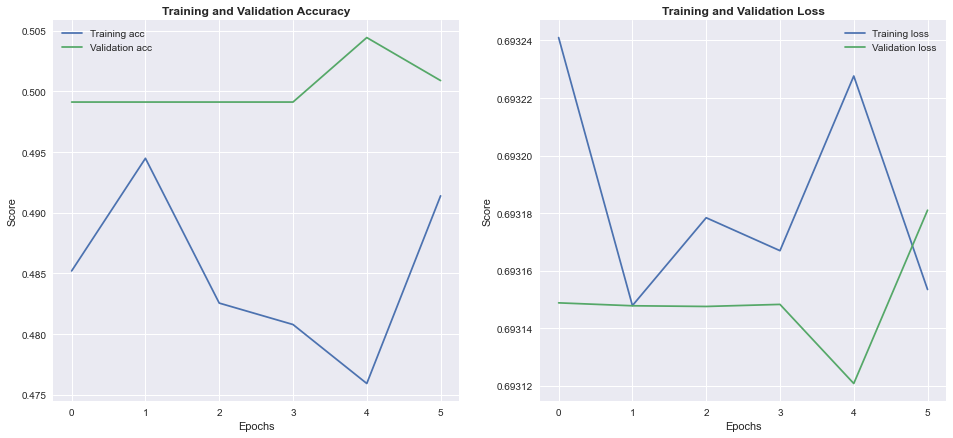

In [416]:
get_model_results(baseline_model, baseline_model_history)

# Model 1: CNN Iteration 1

In [405]:
np.random.seed(7)
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 32)      16416     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)     

In [418]:
model_1.compile(loss='binary_crossentropy', 
                optimizer="sgd", 
                metrics=['acc'])

model_1_history = model_1.fit(train_images, 
                              train_y, 
                              epochs=30, 
                              batch_size=32, 
                              validation_data=(val_images, val_y), 
                              callbacks=[train_callback])

Epoch 1/30


2022-08-01 17:04:16.059564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - ETA: 0s - loss: 0.5113 - acc: 0.7501

2022-08-01 17:04:24.391523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 10s 124ms/step - loss: 0.5113 - acc: 0.7501 - val_loss: 0.4838 - val_acc: 0.7894
Epoch 2/30
71/71 [==============================] - 8s 107ms/step - loss: 0.4950 - acc: 0.7673 - val_loss: 0.4790 - val_acc: 0.7805
Epoch 3/30
71/71 [==============================] - 8s 108ms/step - loss: 0.4883 - acc: 0.7713 - val_loss: 0.5277 - val_acc: 0.7451
Epoch 4/30
71/71 [==============================] - 8s 106ms/step - loss: 0.4793 - acc: 0.7731 - val_loss: 0.4848 - val_acc: 0.7982
Epoch 5/30
71/71 [==============================] - 7s 105ms/step - loss: 0.4609 - acc: 0.7863 - val_loss: 0.4449 - val_acc: 0.8106
Epoch 6/30
71/71 [==============================] - 7s 103ms/step - loss: 0.4561 - acc: 0.7921 - val_loss: 0.5102 - val_acc: 0.7434
Epoch 7/30
71/71 [==============================] - 7s 102ms/step - loss: 0.4442 - acc: 0.7907 - val_loss: 0.4432 - val_acc: 0.7947
Epoch 8/30
71/71 [==============================] - 7s 103ms/step - loss: 0.4167 - acc

23/23 [==============================] - 1s 41ms/step - loss: 0.5111 - acc: 0.8215
Training set loss: 0.124
Training set accuracy: 0.962
----------------------------------------
Test set loss: 0.511
Test set accuracy: 0.822


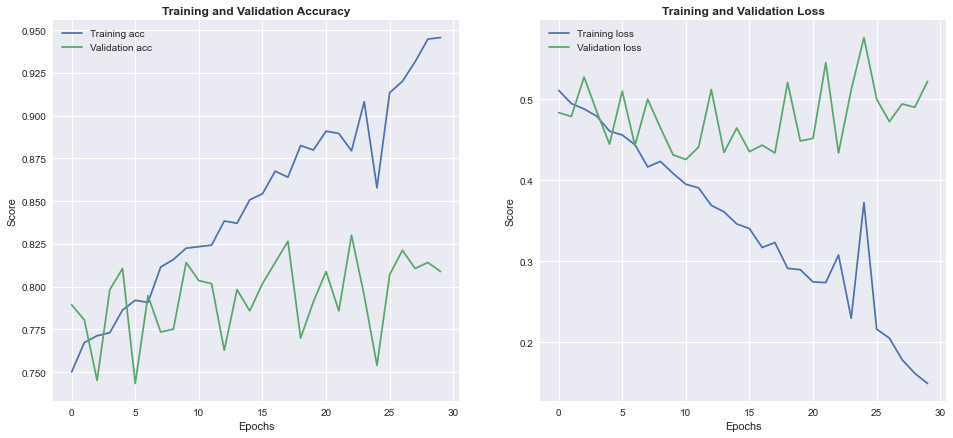

In [419]:
get_model_results(model_1, model_1_history)

In [425]:
y_proba = baseline_model.predict(test_img)
y_proba

23/23 [==============================] - 2s 79ms/step


array([[0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.49997944],
       [0.499

In [424]:
predicted = y_proba.round()
predicted

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

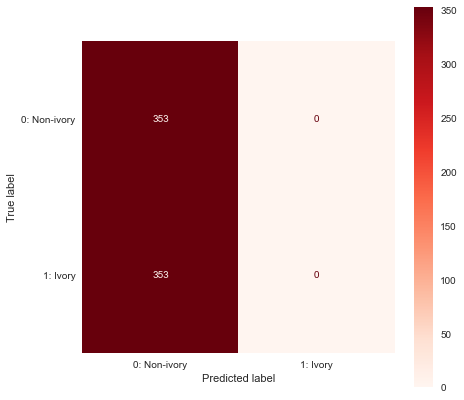

In [457]:
fig, ax = plt.subplots(figsize=(7, 7))

cm = confusion_matrix(test_y, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0: Non-ivory', '1: Ivory'])

disp.plot(cmap='Reds', ax=ax)
plt.grid(False)
plt.show()

In [453]:
y_proba_1 = model_1.predict(test_images)
y_proba_1

2022-08-01 17:45:54.250639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 71ms/step


array([[1.80226881e-02],
       [8.76497447e-01],
       [9.10045385e-01],
       [9.60544705e-01],
       [6.10532761e-01],
       [5.26248030e-02],
       [2.25345194e-01],
       [1.59334525e-01],
       [9.61633205e-01],
       [3.60782444e-01],
       [8.19405198e-01],
       [9.47131157e-01],
       [6.66787088e-01],
       [1.57504961e-01],
       [8.19200277e-01],
       [9.32879090e-01],
       [9.98272300e-01],
       [3.26816469e-01],
       [9.95991170e-01],
       [9.41528440e-01],
       [1.67003423e-02],
       [1.10408971e-02],
       [3.98905156e-03],
       [9.49386477e-01],
       [6.81629241e-01],
       [9.89018798e-01],
       [6.24220297e-02],
       [7.76687562e-02],
       [1.85336471e-01],
       [1.75871432e-01],
       [1.16085209e-01],
       [8.82350981e-01],
       [4.75805014e-01],
       [9.99990344e-01],
       [2.42946427e-02],
       [6.55471861e-01],
       [3.98752004e-01],
       [9.99997258e-01],
       [9.99970794e-01],
       [2.74490178e-01],


In [454]:
predicted_1 = y_proba_1.round()
predicted_1

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],

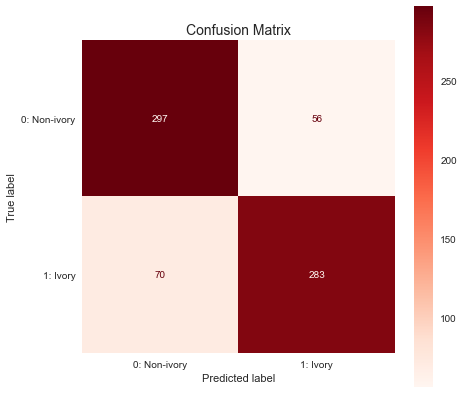

In [528]:
fig, ax = plt.subplots(figsize=(7, 7))

cm = confusion_matrix(test_y, predicted_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0: Non-ivory', '1: Ivory'])

disp.plot(cmap='Reds', ax=ax)
plt.title('Confusion Matrix', size=14)
plt.grid(False)
plt.show()

In [469]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, predicted_1)

In [470]:
roc_auc = metrics.auc(fpr, tpr)

In [516]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='ROC-AUC Curve')

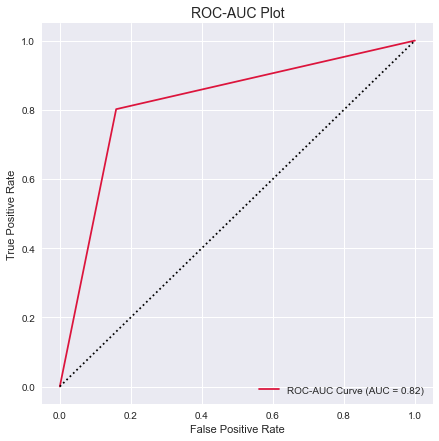

In [527]:
fig, ax = plt.subplots(figsize=(7, 7))

display.plot(c='crimson', ax=ax)
ax.set_title('ROC-AUC Plot', size=14)
ax.plot([0, 1], [0, 1], c='black', linestyle='dotted');